# Movie lens data engineering

This notebook presents more sophisticated feature engineering for the movie lens data. 

Due to the nature of the data set being rich in movie attributes (with no user attributes as well as context of interaction), most feature engineering therefore will be carried out on movies.

## Dataset download

In [1]:
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from nvtabular.utils import download_file

MOVIE_LENS_DATA_PATH = './data/ml-25m/'

if not os.path.isdir(MOVIE_LENS_DATA_PATH):
    download_file(
        "http://files.grouplens.org/datasets/movielens/ml-25m.zip", os.path.join(MOVIE_LENS_DATA_PATH, "ml-25m.zip")
    )
!ls $MOVIE_LENS_DATA_PATH

NVTab_preprocessing  genome-tags.csv  movies.csv	       tags.csv
README.txt	     links.csv	      movies_features.parquet
genome-scores.csv    ml-25m.zip       ratings.csv


In [2]:
import pandas as pd
import numpy as np

In [3]:
movies = pd.read_csv(MOVIE_LENS_DATA_PATH+"movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv(MOVIE_LENS_DATA_PATH+"ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
links = pd.read_csv(MOVIE_LENS_DATA_PATH+"links.csv", dtype={'imdbId':str, 'tmdbId': str})
links.head()

,movieId,imdbId,tmdbId
0,1,0114709,862
1,2,0113497,8844
2,3,0113228,15602
3,4,0114885,31357
4,5,0113041,11862


In [6]:
numeric_features = []
cat_features = []

## Feature engineering for movies

### Movies rating statistics

We extract the average rating & numbers of ratings.

In [7]:
movies_num_ratings = pd.DataFrame(ratings.groupby('movieId').agg({'userId': ['count'],
                                                                  'rating': ['mean']}))

In [8]:
movies_num_ratings.columns = ["_".join(x) for x in movies_num_ratings.columns.ravel()]

In [9]:
movies_num_ratings.head()

,userId_count,rating_mean
movieId,,
1,57309,3.893708
2,24228,3.251527
3,11804,3.142028
4,2523,2.853547
5,11714,3.058434


In [10]:
movies = movies.join(movies_num_ratings, on = 'movieId')

In [11]:
movies.head()

,movieId,title,genres,userId_count,rating_mean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434


In [12]:
numeric_features += ['userId_count', 'rating_mean']

### Extract movie production year

In [13]:
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)

movies['year_cat'] = movies['year']

In [14]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527,1995.0,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028,1995.0,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547,1995.0,1995.0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0


In [15]:
numeric_features += ['year']
cat_features += ['year_cat'] # encode year as both numeric and cat?

### Movies genres
We use one hot encoding for the movie genre.

In [16]:
genre_split = movies['genres'].str.split('|', n=10, expand=True)
genre_split.head()

,0,1,2,3,4,5,6,7,8,9
0,Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None
1,Adventure,Children,Fantasy,None,None,None,None,None,None,None
2,Comedy,Romance,None,None,None,None,None,None,None,None
3,Comedy,Drama,Romance,None,None,None,None,None,None,None
4,Comedy,None,None,None,None,None,None,None,None,None


In [17]:
genres = set()
for i in range(10):
    movies[i] = genre_split[i]
    genres = genres.union(set(genre_split[i].unique()))

In [18]:
genres.discard(None)
genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [19]:
for genre in genres:
    movies[genre] = 0
    for i in range(10):
        movies[genre] = movies[genre] + (movies[i]==genre)

In [20]:
for i in range(10):
    movies.drop(i, axis=1, inplace=True)
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Fantasy,Children,Documentary,...,Animation,Horror,Musical,(no genres listed),Adventure,Romance,Mystery,Sci-Fi,Thriller,Crime
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1,1,0,...,1,0,0,0,1,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,24228.0,3.251527,1995.0,1995.0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,11804.0,3.142028,1995.0,1995.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2523.0,2.853547,1995.0,1995.0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
len(genres)

20

In [22]:
#cat_features += ['genres']

### Content features

We use TF-IDF and SVD to turn text features (title, tag and genres) into numeric feature. 

In [23]:
tags = pd.read_csv(MOVIE_LENS_DATA_PATH+"tags.csv")

# create a mixed dataframe of movies title, genres and all user tags given to each movie
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Fantasy,Children,Documentary,...,(no genres listed),Adventure,Romance,Mystery,Sci-Fi,Thriller,Crime,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1,1,0,...,0,1,0,0,0,0,0,791.0,Owned,1.515175e+09
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1,1,0,...,0,1,0,0,0,0,0,1048.0,imdb top 250,1.172144e+09
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,57309.0,3.893708,1995.0,1995.0,1,1,0,...,0,1,0,0,0,0,0,1361.0,Pixar,1.216146e+09


In [24]:
# create metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                             lambda x: "%s" % ' '.join(x)))


In [25]:
movies['genres'] = movies['genres'].apply(lambda x: ' '.join(x.split('|')))

In [26]:
movies_meta = pd.merge(movies, mixed, on='movieId', how='left')
movies_meta['metadata'] = movies_meta[['genres', 'tag']].apply(
                             lambda x: ' '.join(x), axis = 1)
movies_meta[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy Ow...
1,2,Jumanji (1995),Adventure Children Fantasy Robin Williams time...
2,3,Grumpier Old Men (1995),Comedy Romance funny best friend duringcredits...


#### TF-IDF vectorizer
Next step is to turn the text metadata into a matrix.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_meta['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=movies_meta['movieId'].tolist())
print(tfidf_df.shape)

(62423, 35768)


In [28]:
tfidf_df.head()

,0,1,2,3,4,5,6,7,8,9,...,35758,35759,35760,35761,35762,35763,35764,35765,35766,35767
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
len(tfidf.vocabulary_)

35768

In [30]:
!mkdir ./assets

mkdir: cannot create directory ‘./assets’: File exists


We save the TF-IDF object for subsequent transform of new movies.

In [31]:
import pickle

with open('./assets/movie-lens-tf-idf.pkl', 'wb') as f:
    pickle.dump({"tfidf": tfidf}, f)

#### TF-IDF Transform new movie
Note: for a new test movie, its TF-IDF representation can be computed as below:

In [32]:
new_movie_feat = tfidf.transform(['cartoon'])

In [33]:
new_movie_feat

<1x35768 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

#### SVD on TF-IDF matrix
The TF-IDF matrix is of numeric form, however, it is very high-dimensional and sparse. We use SVD to get an approximation of this matrix using only the most significant eigen vectors.

In [34]:
NUM_LATENT_FACTOR = 128

# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=NUM_LATENT_FACTOR)
latent_matrix = svd.fit_transform(tfidf_df)
 
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()


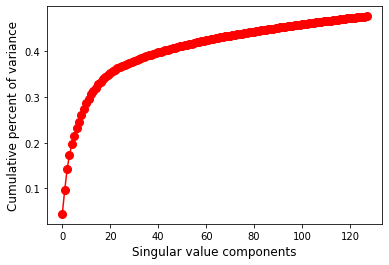

In [35]:
import matplotlib.pyplot as plt
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [36]:
latent_matrix_1_df = pd.DataFrame(latent_matrix,
                                  index=movies_meta['movieId'].tolist())

In [37]:
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
1,0.040733,0.000288,0.051061,0.002787,0.028925,0.011605,-0.090231,0.293034,-0.019821,0.198646,...,-0.023562,-0.017797,-0.025215,0.037634,0.019600,-0.004217,-0.022778,0.003954,0.001942,-0.012485
2,0.013167,0.000391,0.005223,0.001949,0.024602,0.013538,-0.019610,0.082290,-0.009335,0.016648,...,-0.015788,-0.021314,0.008720,0.019173,0.000204,-0.004721,0.004752,0.010792,0.017526,-0.012479
3,0.025699,-0.000123,0.028008,-0.000756,0.000757,0.033766,0.006393,-0.000743,-0.004234,0.001167,...,-0.000846,0.022947,0.003694,0.034160,0.003465,-0.024556,-0.031885,-0.002268,0.021234,-0.005861
4,0.099710,-0.001300,0.028950,-0.003484,-0.008644,0.069895,0.014720,-0.002508,-0.008597,0.004705,...,0.018232,-0.015842,0.040263,-0.016916,0.031898,-0.039114,-0.013873,-0.025863,0.054604,0.014601
5,0.059480,-0.000102,0.083627,-0.001704,0.003635,-0.008453,-0.001699,0.017315,0.003003,0.003468,...,-0.000018,0.046586,0.012729,-0.002504,0.021653,0.002391,0.021781,-0.063815,0.055816,-0.037463


In [38]:
latent_matrix_1_df.set_axis(['SVD_latent_%d'%i for i in range(NUM_LATENT_FACTOR)], axis='columns', inplace=True)
latent_matrix_1_df.columns

Index(['SVD_latent_0', 'SVD_latent_1', 'SVD_latent_2', 'SVD_latent_3',
       'SVD_latent_4', 'SVD_latent_5', 'SVD_latent_6', 'SVD_latent_7',
       'SVD_latent_8', 'SVD_latent_9',
       ...
       'SVD_latent_118', 'SVD_latent_119', 'SVD_latent_120', 'SVD_latent_121',
       'SVD_latent_122', 'SVD_latent_123', 'SVD_latent_124', 'SVD_latent_125',
       'SVD_latent_126', 'SVD_latent_127'],
      dtype='object', length=128)

In [39]:
latent_matrix_1_df['movieId'] = latent_matrix_1_df.index

In [40]:
latent_matrix_1_df.head()

,SVD_latent_0,SVD_latent_1,SVD_latent_2,SVD_latent_3,SVD_latent_4,SVD_latent_5,SVD_latent_6,SVD_latent_7,SVD_latent_8,SVD_latent_9,...,SVD_latent_119,SVD_latent_120,SVD_latent_121,SVD_latent_122,SVD_latent_123,SVD_latent_124,SVD_latent_125,SVD_latent_126,SVD_latent_127,movieId
1,0.040733,0.000288,0.051061,0.002787,0.028925,0.011605,-0.090231,0.293034,-0.019821,0.198646,...,-0.017797,-0.025215,0.037634,0.019600,-0.004217,-0.022778,0.003954,0.001942,-0.012485,1
2,0.013167,0.000391,0.005223,0.001949,0.024602,0.013538,-0.019610,0.082290,-0.009335,0.016648,...,-0.021314,0.008720,0.019173,0.000204,-0.004721,0.004752,0.010792,0.017526,-0.012479,2
3,0.025699,-0.000123,0.028008,-0.000756,0.000757,0.033766,0.006393,-0.000743,-0.004234,0.001167,...,0.022947,0.003694,0.034160,0.003465,-0.024556,-0.031885,-0.002268,0.021234,-0.005861,3
4,0.099710,-0.001300,0.028950,-0.003484,-0.008644,0.069895,0.014720,-0.002508,-0.008597,0.004705,...,-0.015842,0.040263,-0.016916,0.031898,-0.039114,-0.013873,-0.025863,0.054604,0.014601,4
5,0.059480,-0.000102,0.083627,-0.001704,0.003635,-0.008453,-0.001699,0.017315,0.003003,0.003468,...,0.046586,0.012729,-0.002504,0.021653,0.002391,0.021781,-0.063815,0.055816,-0.037463,5


In [41]:
movies = movies.merge(latent_matrix_1_df, on='movieId', how='left')

In [42]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Fantasy,Children,Documentary,...,SVD_latent_118,SVD_latent_119,SVD_latent_120,SVD_latent_121,SVD_latent_122,SVD_latent_123,SVD_latent_124,SVD_latent_125,SVD_latent_126,SVD_latent_127
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,57309.0,3.893708,1995.0,1995.0,1,1,0,...,-0.023562,-0.017797,-0.025215,0.037634,0.019600,-0.004217,-0.022778,0.003954,0.001942,-0.012485
1,2,Jumanji (1995),Adventure Children Fantasy,24228.0,3.251527,1995.0,1995.0,1,1,0,...,-0.015788,-0.021314,0.008720,0.019173,0.000204,-0.004721,0.004752,0.010792,0.017526,-0.012479
2,3,Grumpier Old Men (1995),Comedy Romance,11804.0,3.142028,1995.0,1995.0,0,0,0,...,-0.000846,0.022947,0.003694,0.034160,0.003465,-0.024556,-0.031885,-0.002268,0.021234,-0.005861
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2523.0,2.853547,1995.0,1995.0,0,0,0,...,0.018232,-0.015842,0.040263,-0.016916,0.031898,-0.039114,-0.013873,-0.025863,0.054604,0.014601
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0,0,0,...,-0.000018,0.046586,0.012729,-0.002504,0.021653,0.002391,0.021781,-0.063815,0.055816,-0.037463


In [43]:
numeric_features += ['SVD_latent_%d'%i for i in range(NUM_LATENT_FACTOR)]

#### SVD transform new movie

Note: SVD transform of a new movie (with corresponding TF-IDF features) can be done as follows:

In [44]:
latent_matrix = svd.transform(new_movie_feat)

In [45]:
latent_matrix.shape

(1, 128)

We save the SVD object for subsequent transform of new movies.

In [46]:
with open('./assets/svd.pkl', 'wb') as f:
    pickle.dump({"svd": svd}, f)

###  Popularity score

We compute the [popularity score](https://www.kaggle.com/rounakbanik/movie-recommender-systems) for each movie within the set of all movies as well as within each genre as follows:

```Weighted Rating (WR) = (v/(v+m).R)+(m/(v+m).C)```

where,

    v is the number of votes for the movie
    m is the minimum votes required to be listed in the chart
    R is the average rating of the movie
    C is the mean vote across the whole set


In [47]:
C = ratings['rating'].mean()
C

3.533854451353085

The next step is to determine an appropriate value for m, the minimum votes required to be listed in the chart. We will use 95th percentile as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 95% of the movies in the list.

In [48]:
m = movies_num_ratings['userId_count'].quantile(0.95)
m

1503.3999999999942



Therefore, to qualify to be considered for the chart, a movie has to have at least 1503 votes on IMDB. We also see that the average rating for a movie on IMDB is 3.53 on a scale of 5. 2953 movies qualify to be on our chart.


In [49]:
qualified = movies[movies['userId_count'] >= m]

In [50]:
qualified.shape

(2953, 155)

In [51]:
def weighted_rating(x):
    v = x['userId_count']
    R = x['rating_mean']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [52]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

<ipython-input-52-a4cac61d7166>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['wr'] = qualified.apply(weighted_rating, axis=1)


In [53]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [54]:
qualified.head(5)

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Fantasy,Children,Documentary,...,SVD_latent_119,SVD_latent_120,SVD_latent_121,SVD_latent_122,SVD_latent_123,SVD_latent_124,SVD_latent_125,SVD_latent_126,SVD_latent_127,wr
314,318,"Shawshank Redemption, The (1994)",Crime Drama,81482.0,4.413576,1994.0,1994.0,0,0,0,...,0.036771,0.041516,0.089883,0.020023,0.002629,0.035448,0.021766,-0.058840,0.010120,4.397639
840,858,"Godfather, The (1972)",Crime Drama,52498.0,4.324336,1972.0,1972.0,0,0,0,...,0.019674,-0.014856,0.074597,-0.096019,0.014077,0.078068,0.054773,0.022740,-0.077805,4.302329
49,50,"Usual Suspects, The (1995)",Crime Mystery Thriller,55366.0,4.284353,1995.0,1995.0,0,0,0,...,0.043268,0.046636,0.138999,0.052381,0.008972,-0.017297,-0.003595,-0.008723,0.004281,4.264513
1190,1221,"Godfather: Part II, The (1974)",Crime Drama,34188.0,4.261759,1974.0,1974.0,0,0,0,...,0.018467,0.003778,0.066019,-0.093710,0.014832,0.066433,0.055475,0.025455,-0.081140,4.231098
522,527,Schindler's List (1993),Drama War,60411.0,4.247579,1993.0,1993.0,0,0,0,...,-0.013327,-0.003621,-0.019701,0.008434,-0.006599,0.012949,-0.004815,-0.010442,0.024559,4.230248


In [55]:
cat_features += [g for g in genres]

#### Popularity score per genre

In [56]:
def build_chart(genre, percentile=0.85):
    df = movies[movies[genre] == 1] #filter out genre
    
    C = ratings['rating'].mean()
    m = movies_num_ratings['userId_count'].quantile(percentile)
    
    qualified = df[df['userId_count'] >= m]
    qualified['%s_wr'%genre] = qualified.apply(weighted_rating, axis=1)
    
    qualified = qualified.sort_values('%s_wr'%genre, ascending=False).head(250)
    qualified.reset_index(inplace=True, drop=True)
    qualified['%s_rank'%genre] = qualified.index
    
    return qualified

In [57]:
for genre in tqdm(genres):
     chart = build_chart(genre)
     movies = movies.merge(chart[["movieId", "%s_wr"%genre, "%s_rank"%genre]], on='movieId', how='left')    

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-56-97b558b0f7e9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['%s_wr'%genre] = qualified.apply(weighted_rating, axis=1)
  5%|▌         | 1/20 [00:00<00:04,  4.21it/s]<ipython-input-56-97b558b0f7e9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['%s_wr'%genre] = qualified.apply(weighted_rating, axis=1)
 10%|█         | 2/20 [00:00<00:04,  3.89it/s]<ipython-input-56-97b558b0f7e9>:8: SettingWithCopyWarning: 
A value is trying to be 

In [58]:
movies.fillna(0, inplace=True)

In [59]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Fantasy,Children,Documentary,...,Romance_wr,Romance_rank,Mystery_wr,Mystery_rank,Sci-Fi_wr,Sci-Fi_rank,Thriller_wr,Thriller_rank,Crime_wr,Crime_rank
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,57309.0,3.893708,1995.0,1995.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),Adventure Children Fantasy,24228.0,3.251527,1995.0,1995.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),Comedy Romance,11804.0,3.142028,1995.0,1995.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2523.0,2.853547,1995.0,1995.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
movies.shape

(62423, 195)

In [61]:
numeric_features += ["%s_wr"%g for g in genres]
numeric_features += ["%s_rank"%g for g in genres]

In [62]:
with open('./assets/features.pkl', 'wb') as f:
    pickle.dump({"numeric_features": numeric_features, 'cat_features': cat_features }, f)


In [63]:
print(len(cat_features))
print(len(numeric_features))

21
171


### Merging with IMDB ID

In [64]:
movies = movies.merge(links, on='movieId', how='left')

In [65]:
movies.head()

,movieId,title,genres,userId_count,rating_mean,year,year_cat,Fantasy,Children,Documentary,...,Mystery_wr,Mystery_rank,Sci-Fi_wr,Sci-Fi_rank,Thriller_wr,Thriller_rank,Crime_wr,Crime_rank,imdbId,tmdbId
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,57309.0,3.893708,1995.0,1995.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0114709,862
1,2,Jumanji (1995),Adventure Children Fantasy,24228.0,3.251527,1995.0,1995.0,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0113497,8844
2,3,Grumpier Old Men (1995),Comedy Romance,11804.0,3.142028,1995.0,1995.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0113228,15602
3,4,Waiting to Exhale (1995),Comedy Drama Romance,2523.0,2.853547,1995.0,1995.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0114885,31357
4,5,Father of the Bride Part II (1995),Comedy,11714.0,3.058434,1995.0,1995.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0113041,11862


In [66]:
movies.to_parquet(MOVIE_LENS_DATA_PATH+"movies_features.parquet", index=False)

In [67]:
movies.shape

(62423, 197)

# Divide into train and test

We use all examples for training, except the last-watched movies for testing.

In [68]:
ratings.tail()

,userId,movieId,rating,timestamp
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434
25000094,162541,63876,5.0,1240952515


## Forming binary dataset

To train a DLRM network, we will need binary labels. Herein we will employ a simple strategy. The ratings are on a scale between 1-5. We want to predict a binary target with 1 are all ratings >=4 and 0 are all ratings <=3.

In [69]:
ratings['label'] = 0
ratings.loc[ratings['rating']>3,'label'] = 1
ratings.loc[ratings['rating']<=3,'label'] = 0


In [70]:
MIN_RATINGS = 20
USER_COLUMN = 'userId'
ITEM_COLUMN = 'movieId'

In [71]:
# clean up data
del ratings['rating'], ratings['timestamp']

In [72]:
movies[cat_features] = movies[cat_features].astype('int32')
movies[numeric_features] = movies[numeric_features].astype('float32')

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

In [73]:
train_data = train_data.merge(movies, on='movieId')
train_data.head()

,userId,movieId,label,title,genres,userId_count,rating_mean,year,year_cat,Fantasy,...,Mystery_wr,Mystery_rank,Sci-Fi_wr,Sci-Fi_rank,Thriller_wr,Thriller_rank,Crime_wr,Crime_rank,imdbId,tmdbId
0,124027,56587,1,"Bucket List, The (2007)",Comedy Drama,4083.0,3.592946,2007.0,2007,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0825232,7350
1,126033,56587,1,"Bucket List, The (2007)",Comedy Drama,4083.0,3.592946,2007.0,2007,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0825232,7350
2,42980,56587,0,"Bucket List, The (2007)",Comedy Drama,4083.0,3.592946,2007.0,2007,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0825232,7350
3,68348,56587,1,"Bucket List, The (2007)",Comedy Drama,4083.0,3.592946,2007.0,2007,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0825232,7350
4,113495,56587,1,"Bucket List, The (2007)",Comedy Drama,4083.0,3.592946,2007.0,2007,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0825232,7350


In [74]:
test_data = test_data.merge(movies, on='movieId')
test_data.head()

,userId,movieId,label,title,genres,userId_count,rating_mean,year,year_cat,Fantasy,...,Mystery_wr,Mystery_rank,Sci-Fi_wr,Sci-Fi_rank,Thriller_wr,Thriller_rank,Crime_wr,Crime_rank,imdbId,tmdbId
0,99476,104374,1,About Time (2013),Drama Fantasy Romance,4777.0,3.970379,2013.0,2013,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2194499,122906
1,97150,104374,1,About Time (2013),Drama Fantasy Romance,4777.0,3.970379,2013.0,2013,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2194499,122906
2,56108,104374,1,About Time (2013),Drama Fantasy Romance,4777.0,3.970379,2013.0,2013,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2194499,122906
3,109615,104374,1,About Time (2013),Drama Fantasy Romance,4777.0,3.970379,2013.0,2013,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2194499,122906
4,110819,104374,1,About Time (2013),Drama Fantasy Romance,4777.0,3.970379,2013.0,2013,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2194499,122906


In [75]:
cat_features += ['userId', 'movieId']
#numeric_features = ['rating_mean']

In [76]:
BASE_DIR = MOVIE_LENS_DATA_PATH + 'NVTab_preprocessing/'
!mkdir $BASE_DIR

train_data[cat_features+numeric_features+['label']].to_parquet(BASE_DIR + "train.parquet", row_group_size=1000000, engine="pyarrow")
test_data[cat_features+numeric_features+['label']].to_parquet(BASE_DIR + "test.parquet", row_group_size=1000000, engine="pyarrow")

mkdir: cannot create directory ‘./data/ml-25m/NVTab_preprocessing/’: File exists


In [77]:
!ls -l $BASE_DIR

total 291488
drwxr-xr-x 2 root root      4096 May  6 01:53 test
-rw-r--r-- 1 root root  81789779 May  6 02:02 test.parquet
drwxr-xr-x 3 root root      4096 May  6 01:52 test_dask
drwxr-xr-x 2 root root      4096 May  6 01:53 train
-rw-r--r-- 1 root root 216673815 May  6 02:02 train.parquet


## Preprocessing with NVTabular

In [78]:
# External dependencies
import os
import gc
import pathlib
from os import path
import glob
import shutil

import numpy as np
import cudf

# NVTabular
import nvtabular as nvt
from nvtabular.io import Shuffle
from nvtabular.utils import device_mem_size

In [79]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
import rmm

In [80]:
# define some information about where to get our data
dask_workdir = pathlib.Path(BASE_DIR, "test_dask", "workdir")

# Make sure we have a clean worker space for Dask
if pathlib.Path.is_dir(dask_workdir):
    shutil.rmtree(dask_workdir)
dask_workdir.mkdir(parents=True)

# Get device memory capacity
capacity = device_mem_size(kind="total")

In [81]:
# Deploy a Single-Machine Multi-GPU Cluster
protocol = "tcp"  # "tcp" or "ucx"
#visible_devices = "0,1,2,3,4,5,6,7"  # Select devices to place workers
visible_devices = "0"  # Select devices to place workers
device_spill_frac = 0.5  # Spill GPU-Worker memory to host at this limit.
# Reduce if spilling fails to prevent
# device memory errors.
cluster = None  # (Optional) Specify existing scheduler port
if cluster is None:
    cluster = LocalCUDACluster(
        protocol=protocol,
        CUDA_VISIBLE_DEVICES=visible_devices,
        local_directory=dask_workdir,
        device_memory_limit=capacity * device_spill_frac,
    )

# Create the distributed client
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:38759 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 135.00 GB


# Initialize RMM pool on ALL workers
def _rmm_pool():
    rmm.reinitialize(
        pool_allocator=True,
        initial_pool_size=None,  # Use default size
    )


client.run(_rmm_pool)

In [82]:
CATEGORICAL_COLUMNS = cat_features 
NUMERICAL_COLUMNS = numeric_features
LABEL_COLUMNS = ["label"]

print(len(CATEGORICAL_COLUMNS), len(NUMERICAL_COLUMNS))

23 171


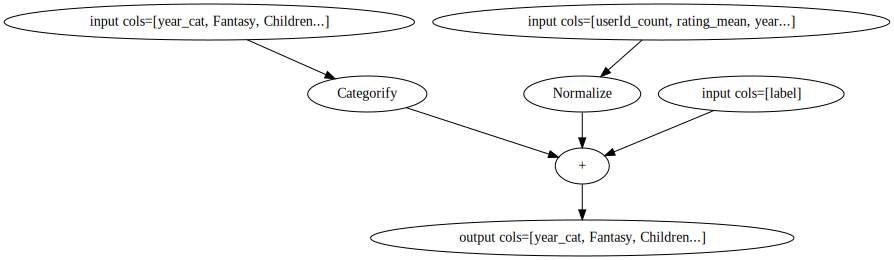

In [83]:
output = (CATEGORICAL_COLUMNS >> nvt.ops.Categorify(cat_cache="device")) + \
         (NUMERICAL_COLUMNS >> nvt.ops.Normalize()) + \
         LABEL_COLUMNS
(output).graph

In [84]:
workflow = nvt.Workflow(output)

In [85]:
!ls -l $BASE_DIR

total 291488
drwxr-xr-x 2 root root      4096 May  6 01:53 test
-rw-r--r-- 1 root root  81789779 May  6 02:02 test.parquet
drwxr-xr-x 3 root root      4096 May  6 02:02 test_dask
drwxr-xr-x 2 root root      4096 May  6 01:53 train
-rw-r--r-- 1 root root 216673815 May  6 02:02 train.parquet


In [86]:
train_dataset = nvt.Dataset(BASE_DIR + "train.parquet", part_size="100MB")
test_dataset = nvt.Dataset(BASE_DIR + "test.parquet", part_size="100MB")

/nvtabular/nvtabular/io/parquet.py:83: UserWarning: Row group memory size (800000000) (bytes) of parquet file is bigger than requested part_size (100000000) for the NVTabular dataset.A row group memory size of 128 MB is generally recommended. You can find info on how to set the row group size of parquet files in https://nvidia.github.io/NVTabular/main/HowItWorks.html#getting-your-data-ready-for-nvtabular
  warnings.warn(


In [87]:
%%time

workflow.fit(train_dataset)

CPU times: user 22.1 s, sys: 4.91 s, total: 27 s
Wall time: 30.5 s


In [88]:
dict_dtypes = {}

for col in CATEGORICAL_COLUMNS:
    dict_dtypes[col] = np.int64

for col in NUMERICAL_COLUMNS:
    dict_dtypes[col] = np.float32
    
for col in LABEL_COLUMNS:
    dict_dtypes[col] = np.float32

In [89]:
train_dir = os.path.join(BASE_DIR, "train")
test_dir = os.path.join(BASE_DIR, "test")
!rm -rf $train_dir && rm -rf $test_dir

In [90]:
workflow.transform(train_dataset).to_parquet(
    output_path=BASE_DIR + "train/",
    shuffle=nvt.io.Shuffle.PER_PARTITION,
    cats=CATEGORICAL_COLUMNS,
    labels=LABEL_COLUMNS,
    conts=NUMERICAL_COLUMNS,
    dtypes=dict_dtypes,
)


In [91]:
workflow.transform(test_dataset).to_parquet(
    output_path=BASE_DIR + "test/",
    shuffle=False,
    cats=CATEGORICAL_COLUMNS,
    labels=LABEL_COLUMNS,
    conts=NUMERICAL_COLUMNS,
    dtypes=dict_dtypes,
)

In [110]:
workflow.save(os.path.join(BASE_DIR, "workflow"))


In [111]:
BASE_DIR

'./data/ml-25m/NVTab_preprocessing/'

In [92]:
import dask 
print(dask.compute(test_dataset.to_ddf().shape))

((5000019, 195),)


In [93]:
print(dask.compute(train_dataset.to_ddf().shape))

((20000076, 195),)


In [94]:
# check data
import pandas as pd

train_read = pd.read_parquet("./data/ml-25m/NVTab_preprocessing/train/")

In [95]:
train_read.head()

,year_cat,Fantasy,Children,Documentary,Western,IMAX,Drama,Film-Noir,Comedy,Action,...,Horror_rank,Musical_rank,(no genres listed)_rank,Adventure_rank,Romance_rank,Mystery_rank,Sci-Fi_rank,Thriller_rank,Crime_rank,label
0,132,2,1,1,1,2,1,1,1,2,...,-0.109239,-0.126785,-0.016294,3.297007,-0.210885,-0.161338,2.631969,-0.261987,-0.233216,1.0
1,116,1,1,1,1,1,2,1,1,1,...,0.167472,-0.126785,-0.016294,-0.275319,-0.210885,0.626265,-0.227471,-0.261987,-0.233216,1.0
2,118,1,1,1,1,1,1,1,2,1,...,-0.109239,-0.126785,-0.016294,-0.275319,0.030721,-0.161338,-0.227471,-0.261987,-0.233216,1.0
3,110,1,1,1,1,1,1,1,1,2,...,-0.109239,-0.126785,-0.016294,4.161279,-0.210885,-0.161338,3.365158,5.378363,-0.233216,1.0
4,112,1,1,1,1,1,1,1,1,2,...,-0.109239,-0.126785,-0.016294,-0.275319,-0.210885,-0.161338,-0.227471,-0.261987,-0.233216,0.0


In [116]:
for x in train_read.max()[:23]:
    print(x)

136.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
162541.0
56585.0


In [112]:
train_read['movieId'].nunique()

56585

In [97]:
test_read = pd.read_parquet("./data/ml-25m/NVTab_preprocessing/test/")
for x in test_read.max()[:23]:
    print(x)

136.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
162541.0
56551.0


In [113]:
test_read['movieId'].nunique()

37118

In [105]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


# Training with HugeCTR

In [98]:
from nvtabular.ops import get_embedding_sizes

embeddings = get_embedding_sizes(workflow)
print(embeddings)

{'(no genres listed)': (3, 16), 'Action': (3, 16), 'Adventure': (3, 16), 'Animation': (3, 16), 'Children': (3, 16), 'Comedy': (3, 16), 'Crime': (3, 16), 'Documentary': (3, 16), 'Drama': (3, 16), 'Fantasy': (3, 16), 'Film-Noir': (3, 16), 'Horror': (3, 16), 'IMAX': (3, 16), 'Musical': (3, 16), 'Mystery': (3, 16), 'Romance': (3, 16), 'Sci-Fi': (3, 16), 'Thriller': (3, 16), 'War': (3, 16), 'Western': (3, 16), 'movieId': (56586, 512), 'userId': (162542, 512), 'year_cat': (137, 25)}


In [115]:
slot_size_array = [embeddings[cat][0] for cat in CATEGORICAL_COLUMNS]
slot_size_array

[137,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 162542,
 56586]

In [100]:
total_cardinality = 0
for cat in embeddings.keys():
    total_cardinality += embeddings[cat][0]
total_cardinality

219325

In [101]:
BASE_DIR

'./data/ml-25m/NVTab_preprocessing/'

In [126]:
import hugectr
from mpi4py import MPI  # noqa

# HugeCTR
solver = hugectr.solver_parser_helper(
    vvgpu=[[0]],
    max_iter=100000,
    max_eval_batches=100,
    batchsize_eval=4096,
    batchsize=4096,
    display=1000,
    eval_interval=10000,
    snapshot=10000,
    i64_input_key=True,
    use_mixed_precision=False,
    repeat_dataset=True,
)
optimizer = hugectr.optimizer.CreateOptimizer(
    optimizer_type=hugectr.Optimizer_t.SGD, use_mixed_precision=False, learning_rate=1e-0
)
model = hugectr.Model(solver, optimizer)
model.add(
    hugectr.Input(
        data_reader_type=hugectr.DataReaderType_t.Parquet,
        source="./data/ml-25m/NVTab_preprocessing/train/_file_list.txt",
        eval_source="./data/ml-25m/NVTab_preprocessing/test/_file_list.txt",
        check_type=hugectr.Check_t.Non,
        label_dim=1,
        label_name="label",
        dense_dim=len(numeric_features),
        dense_name="dense",
        slot_size_array=slot_size_array,
        data_reader_sparse_param_array=[
            hugectr.DataReaderSparseParam(hugectr.DataReaderSparse_t.Localized, len(cat_features), 1, len(cat_features))
        ],
        sparse_names=["data1"],
    )
)
model.add(
    hugectr.SparseEmbedding(
        embedding_type=hugectr.Embedding_t.LocalizedSlotSparseEmbeddingHash,
        max_vocabulary_size_per_gpu=219325,
        embedding_vec_size=128,
        combiner=0,
        sparse_embedding_name="sparse_embedding1",
        bottom_name="data1",
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["dense"],
        top_names=["fc1"],
        num_output=512,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc1"], top_names=["relu1"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu1"],
        top_names=["fc2"],
        num_output=256,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc2"], top_names=["relu2"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu2"],
        top_names=["fc3"],
        num_output=128,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc3"], top_names=["relu3"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.Interaction,
        bottom_names=["relu3", "sparse_embedding1"],
        top_names=["interaction1"],
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["interaction1"],
        top_names=["fc4"],
        num_output=1024,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc4"], top_names=["relu4"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu4"],
        top_names=["fc5"],
        num_output=1024,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc5"], top_names=["relu5"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu5"],
        top_names=["fc6"],
        num_output=512,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc6"], top_names=["relu6"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu6"],
        top_names=["fc7"],
        num_output=256,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc7"], top_names=["relu7"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu7"],
        top_names=["fc8"],
        num_output=1,
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.BinaryCrossEntropyLoss,
        bottom_names=["fc8", "label"],
        top_names=["loss"],
    )
)
model.compile()
model.summary()
model.fit()

# Manual training

In [118]:
%%writefile './model.py'

import hugectr
from mpi4py import MPI  # noqa

# HugeCTR
solver = hugectr.solver_parser_helper(
    vvgpu=[[0]],
    max_iter=50001,
    max_eval_batches=100,
    batchsize_eval=4096,
    batchsize=4096,
    display=1000,
    eval_interval=5000,
    snapshot=5000,
    i64_input_key=True,
    use_mixed_precision=False,
    repeat_dataset=True,
)
optimizer = hugectr.optimizer.CreateOptimizer(
    optimizer_type=hugectr.Optimizer_t.SGD, use_mixed_precision=False, learning_rate=1.0
)
model = hugectr.Model(solver, optimizer)
model.add(
    hugectr.Input(
        data_reader_type=hugectr.DataReaderType_t.Parquet,
        source="./data/ml-25m/NVTab_preprocessing/train/_file_list.txt",
        eval_source="./data/ml-25m/NVTab_preprocessing/test/_file_list.txt",
        check_type=hugectr.Check_t.Non,
        label_dim=1,
        label_name="label",
        dense_dim=75,
        dense_name="dense",
        slot_size_array=[137,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 162542,
 56586],
        data_reader_sparse_param_array=[
            hugectr.DataReaderSparseParam(hugectr.DataReaderSparse_t.Localized, 23, 1, 23)
        ],
        sparse_names=["data1"],
    )
)
model.add(
    hugectr.SparseEmbedding(
        embedding_type=hugectr.Embedding_t.LocalizedSlotSparseEmbeddingHash,
        max_vocabulary_size_per_gpu=500000,
        embedding_vec_size=128,
        combiner=0,
        sparse_embedding_name="sparse_embedding1",
        bottom_name="data1",
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["dense"],
        top_names=["fc1"],
        num_output=512,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc1"], top_names=["relu1"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu1"],
        top_names=["fc2"],
        num_output=256,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc2"], top_names=["relu2"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu2"],
        top_names=["fc3"],
        num_output=128,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc3"], top_names=["relu3"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.Interaction,
        bottom_names=["relu3", "sparse_embedding1"],
        top_names=["interaction1"],
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["interaction1"],
        top_names=["fc4"],
        num_output=1024,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc4"], top_names=["relu4"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu4"],
        top_names=["fc5"],
        num_output=1024,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc5"], top_names=["relu5"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu5"],
        top_names=["fc6"],
        num_output=512,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc6"], top_names=["relu6"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu6"],
        top_names=["fc7"],
        num_output=256,
    )
)
model.add(
    hugectr.DenseLayer(layer_type=hugectr.Layer_t.ReLU, bottom_names=["fc7"], top_names=["relu7"])
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.InnerProduct,
        bottom_names=["relu7"],
        top_names=["fc8"],
        num_output=1,
    )
)
model.add(
    hugectr.DenseLayer(
        layer_type=hugectr.Layer_t.BinaryCrossEntropyLoss,
        bottom_names=["fc8", "label"],
        top_names=["loss"],
    )
)
model.compile()
model.summary()
model.fit()

Overwriting ./model.py


In [119]:
!python model.py

===================================Model Init====================================
[06d05h58m58s][HUGECTR][INFO]: Global seed is 168152721
[06d05h58m59s][HUGECTR][INFO]: Peer-to-peer access cannot be fully enabled.
Device 0: Quadro GV100
[06d05h58m59s][HUGECTR][INFO]: num of DataReader workers: 1
[06d05h58m59s][HUGECTR][INFO]: num_internal_buffers 1
[06d05h58m59s][HUGECTR][INFO]: num_internal_buffers 1
[06d05h58m59s][HUGECTR][INFO]: Vocabulary size: 219325
[06d05h58m59s][HUGECTR][INFO]: max_vocabulary_size_per_gpu_=500000
[06d05h58m59s][HUGECTR][INFO]: All2All Warmup Start
[06d05h58m59s][HUGECTR][INFO]: All2All Warmup End
[06d05h59m21s][HUGECTR][INFO]: gpu0 start to init embedding
[06d05h59m21s][HUGECTR][INFO]: gpu0 init embedding done
==================================Model Summary==================================
Label Name                    Dense Name                    Sparse Name                   
label                         dense                         data1                 

# Export to Triton

In [123]:
!mkdir -p  /model/movielens_triton/1/
!mv *_90000.model /model/movielens_triton/1/

In [320]:
%%writefile '/model/movielens_triton/1/movielens.json'

{
   "inference": {
    "max_batchsize": 4096,
    "hit_rate_threshold": 0.6,
    "dense_model_file": "/model/models/movielens/1/_dense_90000.model",
    "sparse_model_file": "/model/models/movielens/1/0_sparse_90000.model",
    "label": 1,
    "input_key_type": "I64"
  },
  "layers": [
    {
      "name": "data",
      "type": "Data",
      "format": "Parquet",
      "slot_size_array": [137,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 162542,
 56586],
      "source": "/model/data/train/_file_list.txt",
      "eval_source": "/model/data/valid/_file_list.txt",
      "check": "Sum",
      "label": {
        "top": "label",
        "label_dim": 1
      },
      "dense": {
        "top": "dense",
        "dense_dim": 171
      },
      "sparse": [
        {
          "top": "data1",
          "type": "DistributedSlot",
          "max_feature_num_per_sample": 23,
          "slot_num": 23
        }
      ]
    },
    {
      "name": "sparse_embedding1",
      "type": "LocalizedSlotSparseEmbeddingOneHot",
      "bottom": "data1",
      "top": "sparse_embedding1",
      "sparse_embedding_hparam": {
        "slot_size_array": [137,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 162542,
 56586],
        "embedding_vec_size": 128,
        "combiner": 0
      }
    },

    {
      "name": "fc1",
      "type": "InnerProduct",
      "bottom": "dense",
      "top": "fc1",
      "fc_param": {
        "num_output": 512
      }
    },

    {
      "name": "fc2",
      "type": "InnerProduct",
      "bottom": "fc1",
      "top": "fc2",
      "fc_param": {
        "num_output": 256
      }
    },

   
    {
      "name": "fc3",
      "type": "InnerProduct",
      "bottom": "fc2",
      "top": "fc3",
      "fc_param": {
        "num_output": 128
      }
    },

    {
      "name": "interaction1",
      "type": "Interaction",
      "bottom": ["fc3", "sparse_embedding1"],
      "top": "interaction1"
    },

    {
      "name": "fc4",
      "type": "InnerProduct",
      "bottom": "interaction1",
      "top": "fc4",
       "fc_param": {
        "num_output": 1024
      }
    },

    {
      "name": "fc5",
      "type": "InnerProduct",
      "bottom": "fc4",
      "top": "fc5",
      "fc_param": {
        "num_output": 1024
      }
    },

    {
      "name": "fc6",
      "type": "InnerProduct",
      "bottom": "fc5",
      "top": "fc6",
      "fc_param": {
        "num_output": 512
      }
    },

    {
      "name": "fc7",
      "type": "InnerProduct",
      "bottom": "fc6",
      "top": "fc7",
      "fc_param": {
        "num_output": 256
      }
    },

    {
      "name": "fc8",
      "type": "InnerProduct",
      "bottom": "fc7",
      "top": "fc8",
      "fc_param": {
        "num_output": 1
      }
    },
    
    {
      "name": "sigmoid",
      "type": "Sigmoid",
      "bottom": "fc8",
      "top": "sigmoid"
    } 
  ]
}



Overwriting /model/movielens_triton/1/movielens.json


In [321]:
from nvtabular.inference.triton import export_hugectr_ensemble

hugectr_params = dict()
hugectr_params["config"] = "/model/movielens_triton/1/movielens.json"
hugectr_params["slots"] = 23
hugectr_params["max_nnz"] = 23
hugectr_params["embedding_vector_size"] = 128
hugectr_params["n_outputs"] = 1
export_hugectr_ensemble(
    workflow=workflow,
    hugectr_model_path="/model/movielens_triton/1/",
    hugectr_params=hugectr_params,
    name="movielens",
    output_path="/model/models-movies-dlrm/",
    label_columns=["label"],
    cats=CATEGORICAL_COLUMNS,
    conts=NUMERICAL_COLUMNS,
    max_batch_size=4096,
)

# Starting inference docker

Start Merlin inference docker image while mounting the directory containing the Triton model.

```
docker run -it --gpus=all -p 8000:8000 -p 8001:8001 -p 8002:8002 -v ${PWD}:/model nvcr.io/nvidia/merlin/merlin-inference:0.5
source activate merlin
```

```
tritonserver --model-repository=/model/models-movies-dlrm --backend-config=hugectr,movielens=/model/models-movies-dlrm/movielens/1/movielens.json --backend-config=hugectr,supportlonglong=true --model-control-mode=explicit 
```

In [322]:
import tritonclient.grpc as httpclient

import cudf
import numpy as np

# disable warnings
import warnings

warnings.filterwarnings("ignore")


In [323]:
import tritonhttpclient

try:
    triton_client = tritonhttpclient.InferenceServerClient(url="localhost:8000", verbose=True)
    print("client created.")
except Exception as e:
    print("channel creation failed: " + str(e))

client created.


In [324]:
triton_client.is_server_live()

GET /v2/health/live, headers None
<HTTPSocketPoolResponse status=200 headers={'content-length': '0', 'content-type': 'text/plain'}>


True

In [325]:
triton_client.get_model_repository_index()

POST /v2/repository/index, headers None

<HTTPSocketPoolResponse status=200 headers={'content-type': 'application/json', 'content-length': '72'}>
bytearray(b'[{"name":"movielens"},{"name":"movielens_ens"},{"name":"movielens_nvt"}]')


[{'name': 'movielens'}, {'name': 'movielens_ens'}, {'name': 'movielens_nvt'}]

In [326]:
%%time

triton_client.load_model(model_name="movielens_nvt")

POST /v2/repository/models/movielens_nvt/load, headers None

<HTTPSocketPoolResponse status=200 headers={'content-type': 'application/json', 'content-length': '0'}>
Loaded model 'movielens_nvt'
CPU times: user 223 ms, sys: 578 ms, total: 802 ms
Wall time: 4.13 s


In [327]:
%%time

triton_client.load_model(model_name="movielens")

POST /v2/repository/models/movielens/load, headers None

<HTTPSocketPoolResponse status=200 headers={'content-type': 'application/json', 'content-length': '0'}>
Loaded model 'movielens'
CPU times: user 335 ms, sys: 843 ms, total: 1.18 s
Wall time: 6.24 s


In [328]:
%%time

triton_client.load_model(model_name="movielens_ens")

POST /v2/repository/models/movielens_ens/load, headers None

<HTTPSocketPoolResponse status=200 headers={'content-type': 'application/json', 'content-length': '0'}>
Loaded model 'movielens_ens'
CPU times: user 270 ms, sys: 667 ms, total: 937 ms
Wall time: 4.59 s


In [329]:
#cat_features

In [330]:
#numeric_features

In [332]:
from tritonclient.utils import np_to_triton_dtype

model_name = "movielens_ens"
#col_names = cat_features+numeric_features+['label']
col_names = cat_features+numeric_features

# read in a batch of data to get transforms for
batch = cudf.read_parquet("/model/data/test.parquet", num_rows=4096)[col_names]
print(batch, "\n")

# convert the batch to a triton inputs
columns = [(col, batch[col]) for col in col_names]
inputs = []

#col_dtypes = (len(cat_features)-2)*[np.int32] + 2*[np.int64] + len(numeric_features) * [np.float32] + [np.int64]
col_dtypes = (len(cat_features)-2)*[np.int32] + 2*[np.int64] + len(numeric_features) * [np.float32]

#col_dtypes = (len(cat_features))*[np.int64] + len(numeric_features) * [np.float32]

for i, (name, col) in enumerate(columns):
    d = col.values_host.astype(col_dtypes[i])
    d = d.reshape(len(d), 1)
    inputs.append(httpclient.InferInput(name, d.shape, np_to_triton_dtype(col_dtypes[i])))
    inputs[i].set_data_from_numpy(d)
# placeholder variables for the output
outputs = []
outputs.append(httpclient.InferRequestedOutput("OUTPUT0"))
# make the request
with httpclient.InferenceServerClient("localhost:8001") as client:
    response = client.infer(model_name, inputs, request_id=str(1), outputs=outputs)
# print(response.as_numpy('OUTPUT0'))
print("predicted sigmoid result:\n", response.as_numpy("OUTPUT0"))

      year_cat  Fantasy  Children  Documentary  Western  IMAX  Drama  \
0         2013        1         0            0        0     0      1   
1         2013        1         0            0        0     0      1   
2         2013        1         0            0        0     0      1   
3         2013        1         0            0        0     0      1   
4         2013        1         0            0        0     0      1   
...        ...      ...       ...          ...      ...   ...    ...   
4091      2003        1         0            0        0     0      1   
4092      2003        1         0            0        0     0      1   
4093      2003        1         0            0        0     0      1   
4094      2003        1         0            0        0     0      1   
4095      2003        1         0            0        0     0      1   

      Film-Noir  Comedy  Action  ...  Animation_rank  Horror_rank  \
0             0       0       0  ...             0.0          0.0 

In [333]:
response.as_numpy("OUTPUT0").shape

(4096,)

# Compute AUC on test data

In [334]:
from tritonclient.utils import np_to_triton_dtype
import numpy as np

model_name = "movielens_ens"
#col_names = cat_features+numeric_features+['label']
col_names = cat_features+numeric_features

# read in a batch of data to get transforms for
data = cudf.read_parquet("/model/data/test.parquet")[col_names]

num_batches = len(data)//4096
num_batches


1220

In [335]:
batches = np.array_split(np.arange(len(data)), num_batches+1)

In [336]:
data.loc[batches[0]]

,year_cat,Fantasy,Children,Documentary,Western,IMAX,Drama,Film-Noir,Comedy,Action,...,Animation_rank,Horror_rank,Musical_rank,(no genres listed)_rank,Adventure_rank,Romance_rank,Mystery_rank,Sci-Fi_rank,Thriller_rank,Crime_rank
0,2013,1,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0
1,2013,1,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0
2,2013,1,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0
3,2013,1,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0
4,2013,1,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,2003,1,0,0,0,0,1,0,0,1,...,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0
4092,2003,1,0,0,0,0,1,0,0,1,...,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0
4093,2003,1,0,0,0,0,1,0,0,1,...,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0
4094,2003,1,0,0,0,0,1,0,0,1,...,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0


In [347]:
from tqdm import tqdm
from time import time

label=[]

data_prep_time = 0
infer_time = 0

#for _, batch in tqdm(enumerate(batches)):
start_batch = 0
end_batch = 4095
batch_cnt = 0

while end_batch<len(data):
    start_time = time()
    batch = data.loc[start_batch:end_batch]
    # convert the batch to a triton inputs
    columns = [(col, batch[col]) for col in col_names]
    inputs = []

    #col_dtypes = (len(cat_features)-2)*[np.int32] + 2*[np.int64] + len(numeric_features) * [np.float32] + [np.int64]
    col_dtypes = (len(cat_features)-2)*[np.int32] + 2*[np.int64] + len(numeric_features) * [np.float32]

    #col_dtypes = (len(cat_features))*[np.int64] + len(numeric_features) * [np.float32]

    for i, (name, col) in enumerate(columns):
        d = col.values_host.astype(col_dtypes[i])
        d = d.reshape(len(d), 1)
        inputs.append(httpclient.InferInput(name, d.shape, np_to_triton_dtype(col_dtypes[i])))
        inputs[i].set_data_from_numpy(d)
    # placeholder variables for the output
    outputs = []
    outputs.append(httpclient.InferRequestedOutput("OUTPUT0"))
    
    data_prep_time += time()-start_time
    
    start_time = time()
    # make the request
    with httpclient.InferenceServerClient("localhost:8001") as client:
        response = client.infer(model_name, inputs, request_id=str(1), outputs=outputs)
    # print(response.as_numpy('OUTPUT0'))
    #print("predicted sigmoid result:\n", response.as_numpy("OUTPUT0"))
    label.append(response.as_numpy("OUTPUT0"))
    infer_time += time()-start_time

    start_batch += 4096
    end_batch += 4096
    batch_cnt += 1
    
    if batch_cnt%10==0:
        print("Ave. data prep time: ", data_prep_time/batch_cnt)
        print("Ave. infer time: ", infer_time/batch_cnt)
        print("%d/%d"%(end_batch,len(data)))
        


Ave. data prep time:  0.1052236795425415
Ave. infer time:  0.6026193141937256
45055/5000019
Ave. data prep time:  0.10657610893249511
Ave. infer time:  0.6219666481018067
86015/5000019
Ave. data prep time:  0.10633664925893148
Ave. infer time:  0.6183749675750733
126975/5000019
Ave. data prep time:  0.10615499019622802
Ave. infer time:  0.6181314766407013
167935/5000019
Ave. data prep time:  0.10624255180358887
Ave. infer time:  0.621261944770813
208895/5000019
Ave. data prep time:  0.10596995353698731
Ave. infer time:  0.6218619386355082
249855/5000019
Ave. data prep time:  0.10620498657226562
Ave. infer time:  0.6213743209838867
290815/5000019
Ave. data prep time:  0.10642771720886231
Ave. infer time:  0.6206143587827683
331775/5000019
Ave. data prep time:  0.10815977785322402
Ave. infer time:  0.618775012758043
372735/5000019
Ave. data prep time:  0.10837648630142212
Ave. infer time:  0.6195801162719726
413695/5000019
Ave. data prep time:  0.10843983130021528
Ave. infer time:  0.618